In [9]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from deskew import determine_skew
from skimage.transform import rotate
import os

from pdf2image import convert_from_path
# from img2table.ocr import EasyOCR
# from img2table.document import Image

In [6]:
# preprocess image
def preprocess_image(image):
    preprocess_image = image.copy()
    return preprocess_image

#load reader
def load_reader(lang):
    reader = easyocr.Reader([lang])
    return reader

# extract text using ocr
def extract_text(image, reader):
    result = reader.readtext(image)
    return result


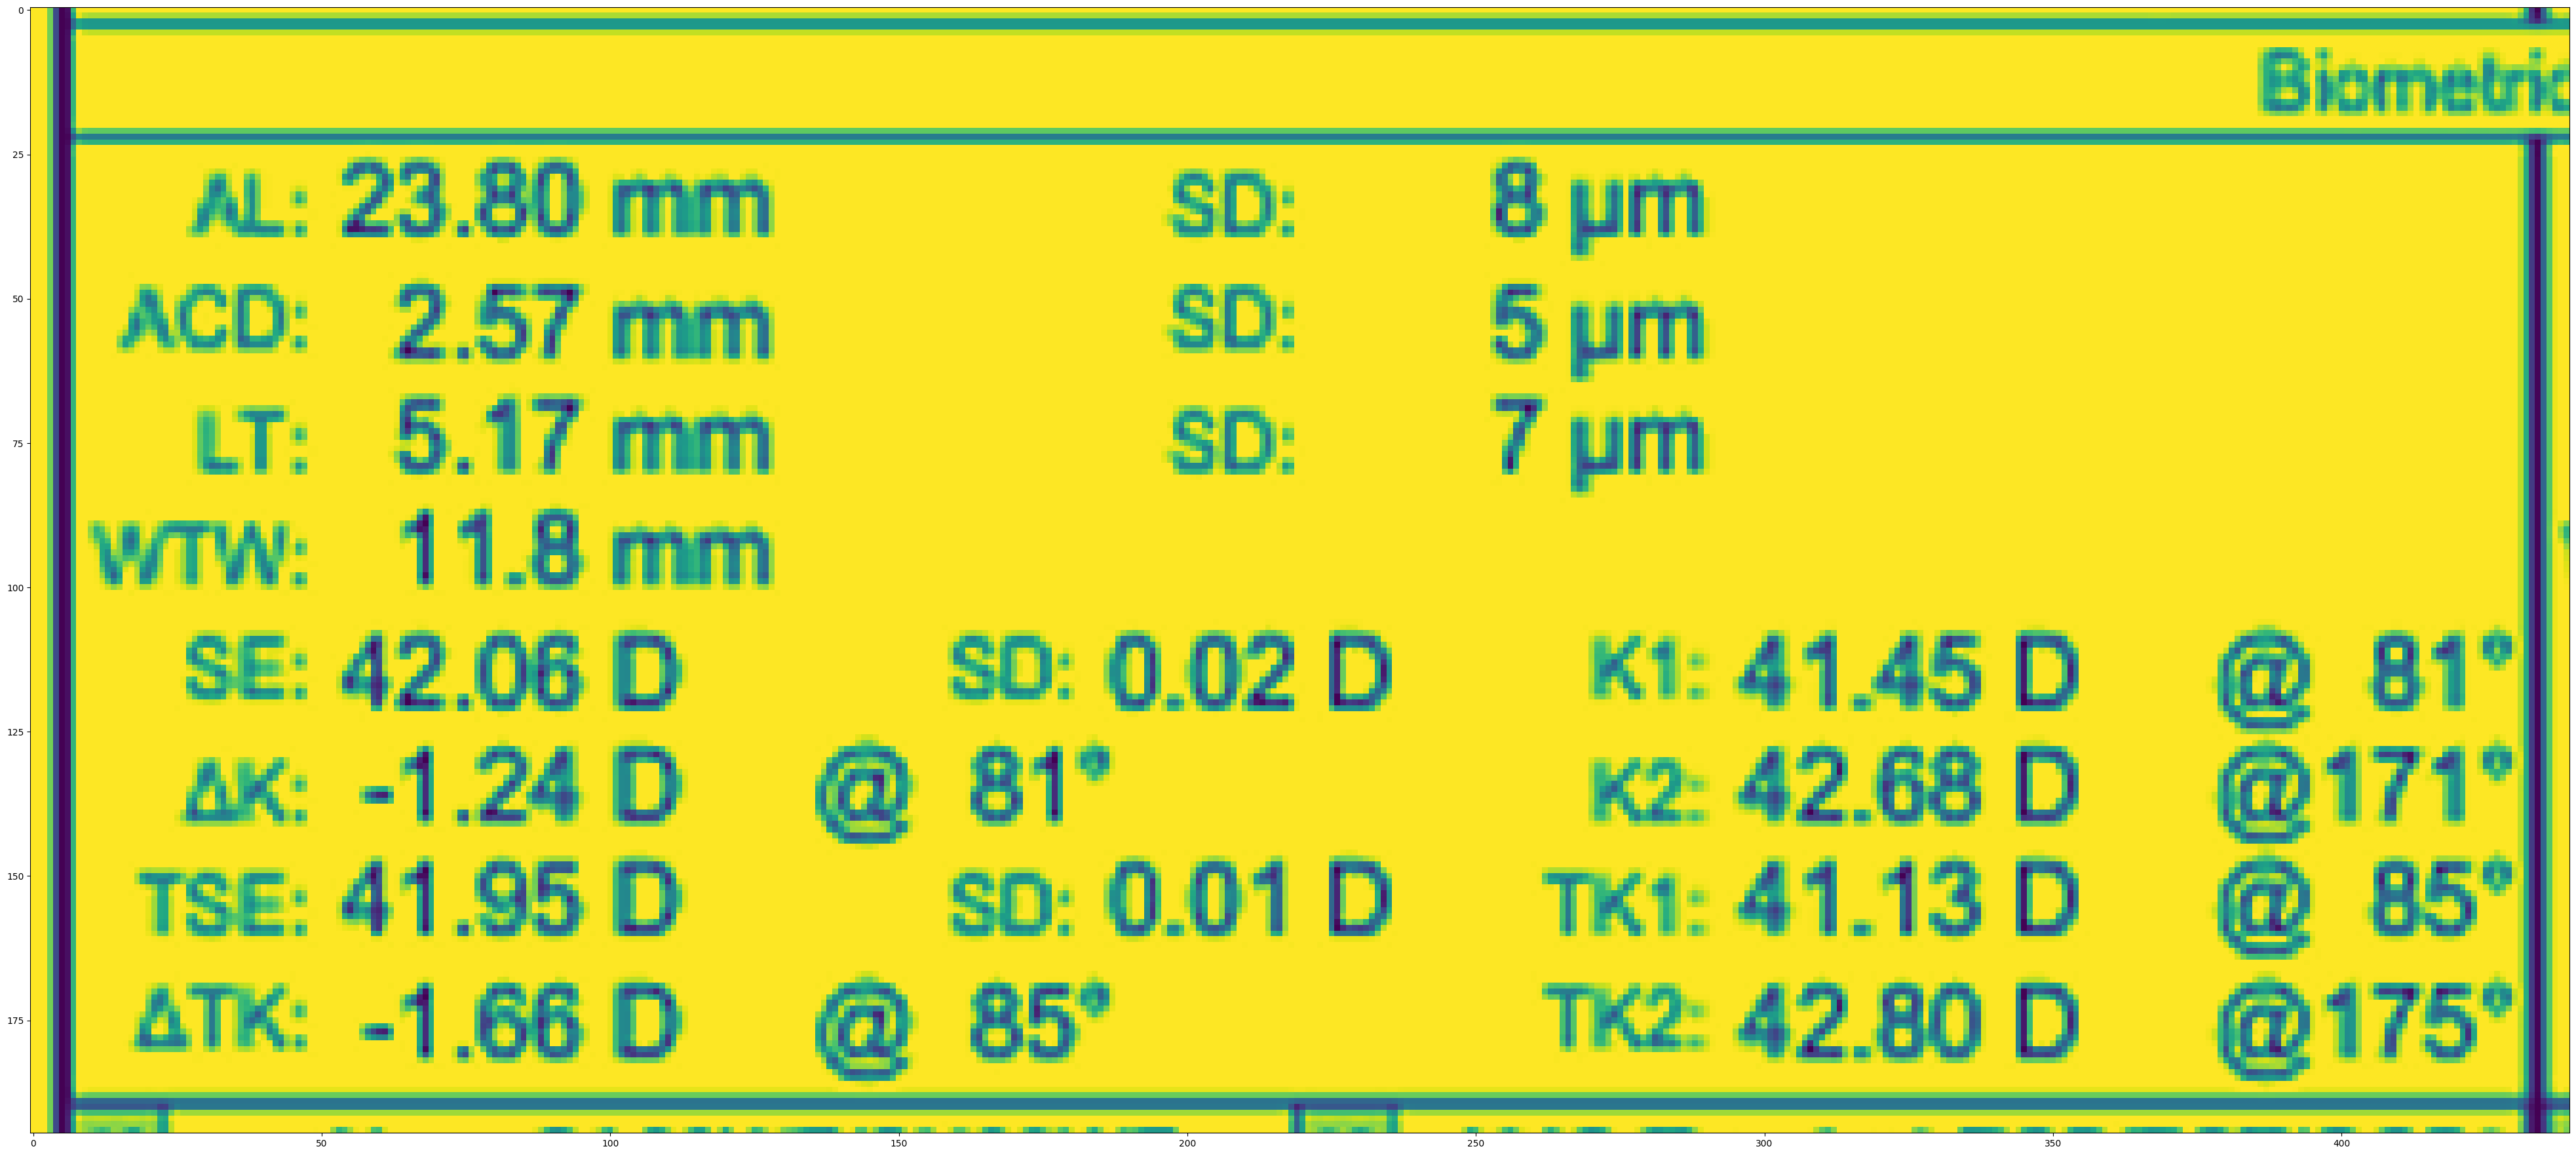

In [10]:
# import image
path = 'Sample/IOL.png'
img = cv2.imread(path)
# gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# resize image
gray = cv2.resize(gray, (1000, 1500), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# crop
sample = gray[600:795, 80:520]
# sample = gray[600:650, 80:240]
# save image
cv2.imwrite('Sample/sample.png', sample)
plt.figure(figsize=(50, 50))
plt.imshow(sample)

In [5]:
# ocr
reader = load_reader('en')
result = extract_text(sample, reader)
result

[([[385, 7], [437, 7], [437, 21], [385, 21]], 'bizineui', 0.1166300593990226),
 ([[25, 23], [131, 23], [131, 43], [25, 43]],
  'AL: 23.80 mm',
  0.39911998035735996),
 ([[197, 27], [223, 27], [223, 43], [197, 43]], 'SD;', 0.808453929568435),
 ([[251, 25], [293, 25], [293, 45], [251, 45]], '8 pm', 0.42950848966251803),
 ([[13, 43], [51, 43], [51, 63], [13, 63]], 'ACD:', 0.9793891906738281),
 ([[59, 45], [131, 45], [131, 65], [59, 65]], '2.57 mm', 0.6610908644818098),
 ([[195, 45], [223, 45], [223, 63], [195, 63]], 'SD:', 0.5758937001228333),
 ([[253, 47], [293, 47], [293, 65], [253, 65]], '5 UM', 0.13009047508239746),
 ([[27, 69], [51, 69], [51, 83], [27, 83]], 'L;', 0.9000778420010155),
 ([[63, 65], [131, 65], [131, 83], [63, 83]], '5.17 Mm', 0.5495738726203193),
 ([[197, 67], [223, 67], [223, 85], [197, 85]], 'SD:', 0.8514934283669852),
 ([[265, 69], [293, 69], [293, 85], [265, 85]], 'UM', 0.40235100997622125),
 ([[11, 87], [53, 87], [53, 103], [11, 103]], 'Vw:', 0.2655155853283416),


In [11]:
import cv2
import pandas as pd
from paddleocr import PPStructure

In [17]:
table_engine = PPStructure(recovery=True, return_ocr_result_in_table=True)

[2023/11/27 01:46:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\earth/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_len

In [18]:
# img = cv2.imread(path)
result = table_engine(sample)

for line in result:
    line.pop('img')
    if line.get("type") == "table":
        html_table = line.get("res").get("html")
        html_data = pd.read_html(html_table)
        pd.DataFrame(html_data[0])

[2023/11/27 01:46:23] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.10779070854187012
[2023/11/27 01:46:27] ppocr DEBUG: rec_res num  : 27, elapsed : 3.5370101928710938


In [27]:
results

NameError: name 'results' is not defined